# Import libraries and dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 200

In [2]:
df = pd.read_csv(r"C:\Users\Cris\Documents\Repos\TitanicML\titanic_train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Drop Passenger ID since it is redundant
df.drop(columns=["PassengerId"], inplace=True)

# Exploratory Data Analysis

In [18]:
# Check details of our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    uint8  
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Alone        891 non-null    int32  
 12  Class1       891 non-null    uint8  
 13  Class2       891 non-null    uint8  
 14  Class3       891 non-null    uint8  
 15  Cherbourg    891 non-null    uint8  
 16  Queenstown   891 non-null    uint8  
 17  Southampton  891 non-null    uint8  
dtypes: float64(2), int32(1), int64(4), object(4), uint

## Missing Values

In [4]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

It appears that there are 2 missing values for embarking location, 177 missing values for Age, and an important 687 null values in the Cabin column. We shall deal with these situations the following ways per column.

### Embarked

In [5]:
df[df.Embarked.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Since there are only two missing rows for this category, it seems reasonable to simply drop these values, since the loss of information would be negligible. However, we could predict the two missing values with a simulation based on Embarked port occurrence.

In [13]:
embarked_probs = df.Embarked[df.Embarked.notna()].value_counts()
print(embarked_probs/embarked_probs.sum())

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64


So, given the distribution of ports, one shall assign the probability of embarking in a given port with those proportions. Therefore the simulation yields

In [45]:
import random

embarked_simulation = random.choices(population=embarked_probs.index.to_list(), weights=embarked_probs.to_list(), k=2)
print(embarked_simulation)

['Q', 'S']


# ORGANIZE THIS LATER

In [3]:
# # Turn sex into one-hot, 1 is female, 0 is male
# df["Sex"] = pd.get_dummies(df.Sex)["female"]
# df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    uint8  
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4), uint8(1)
memory usage: 70.6+ KB


## Age

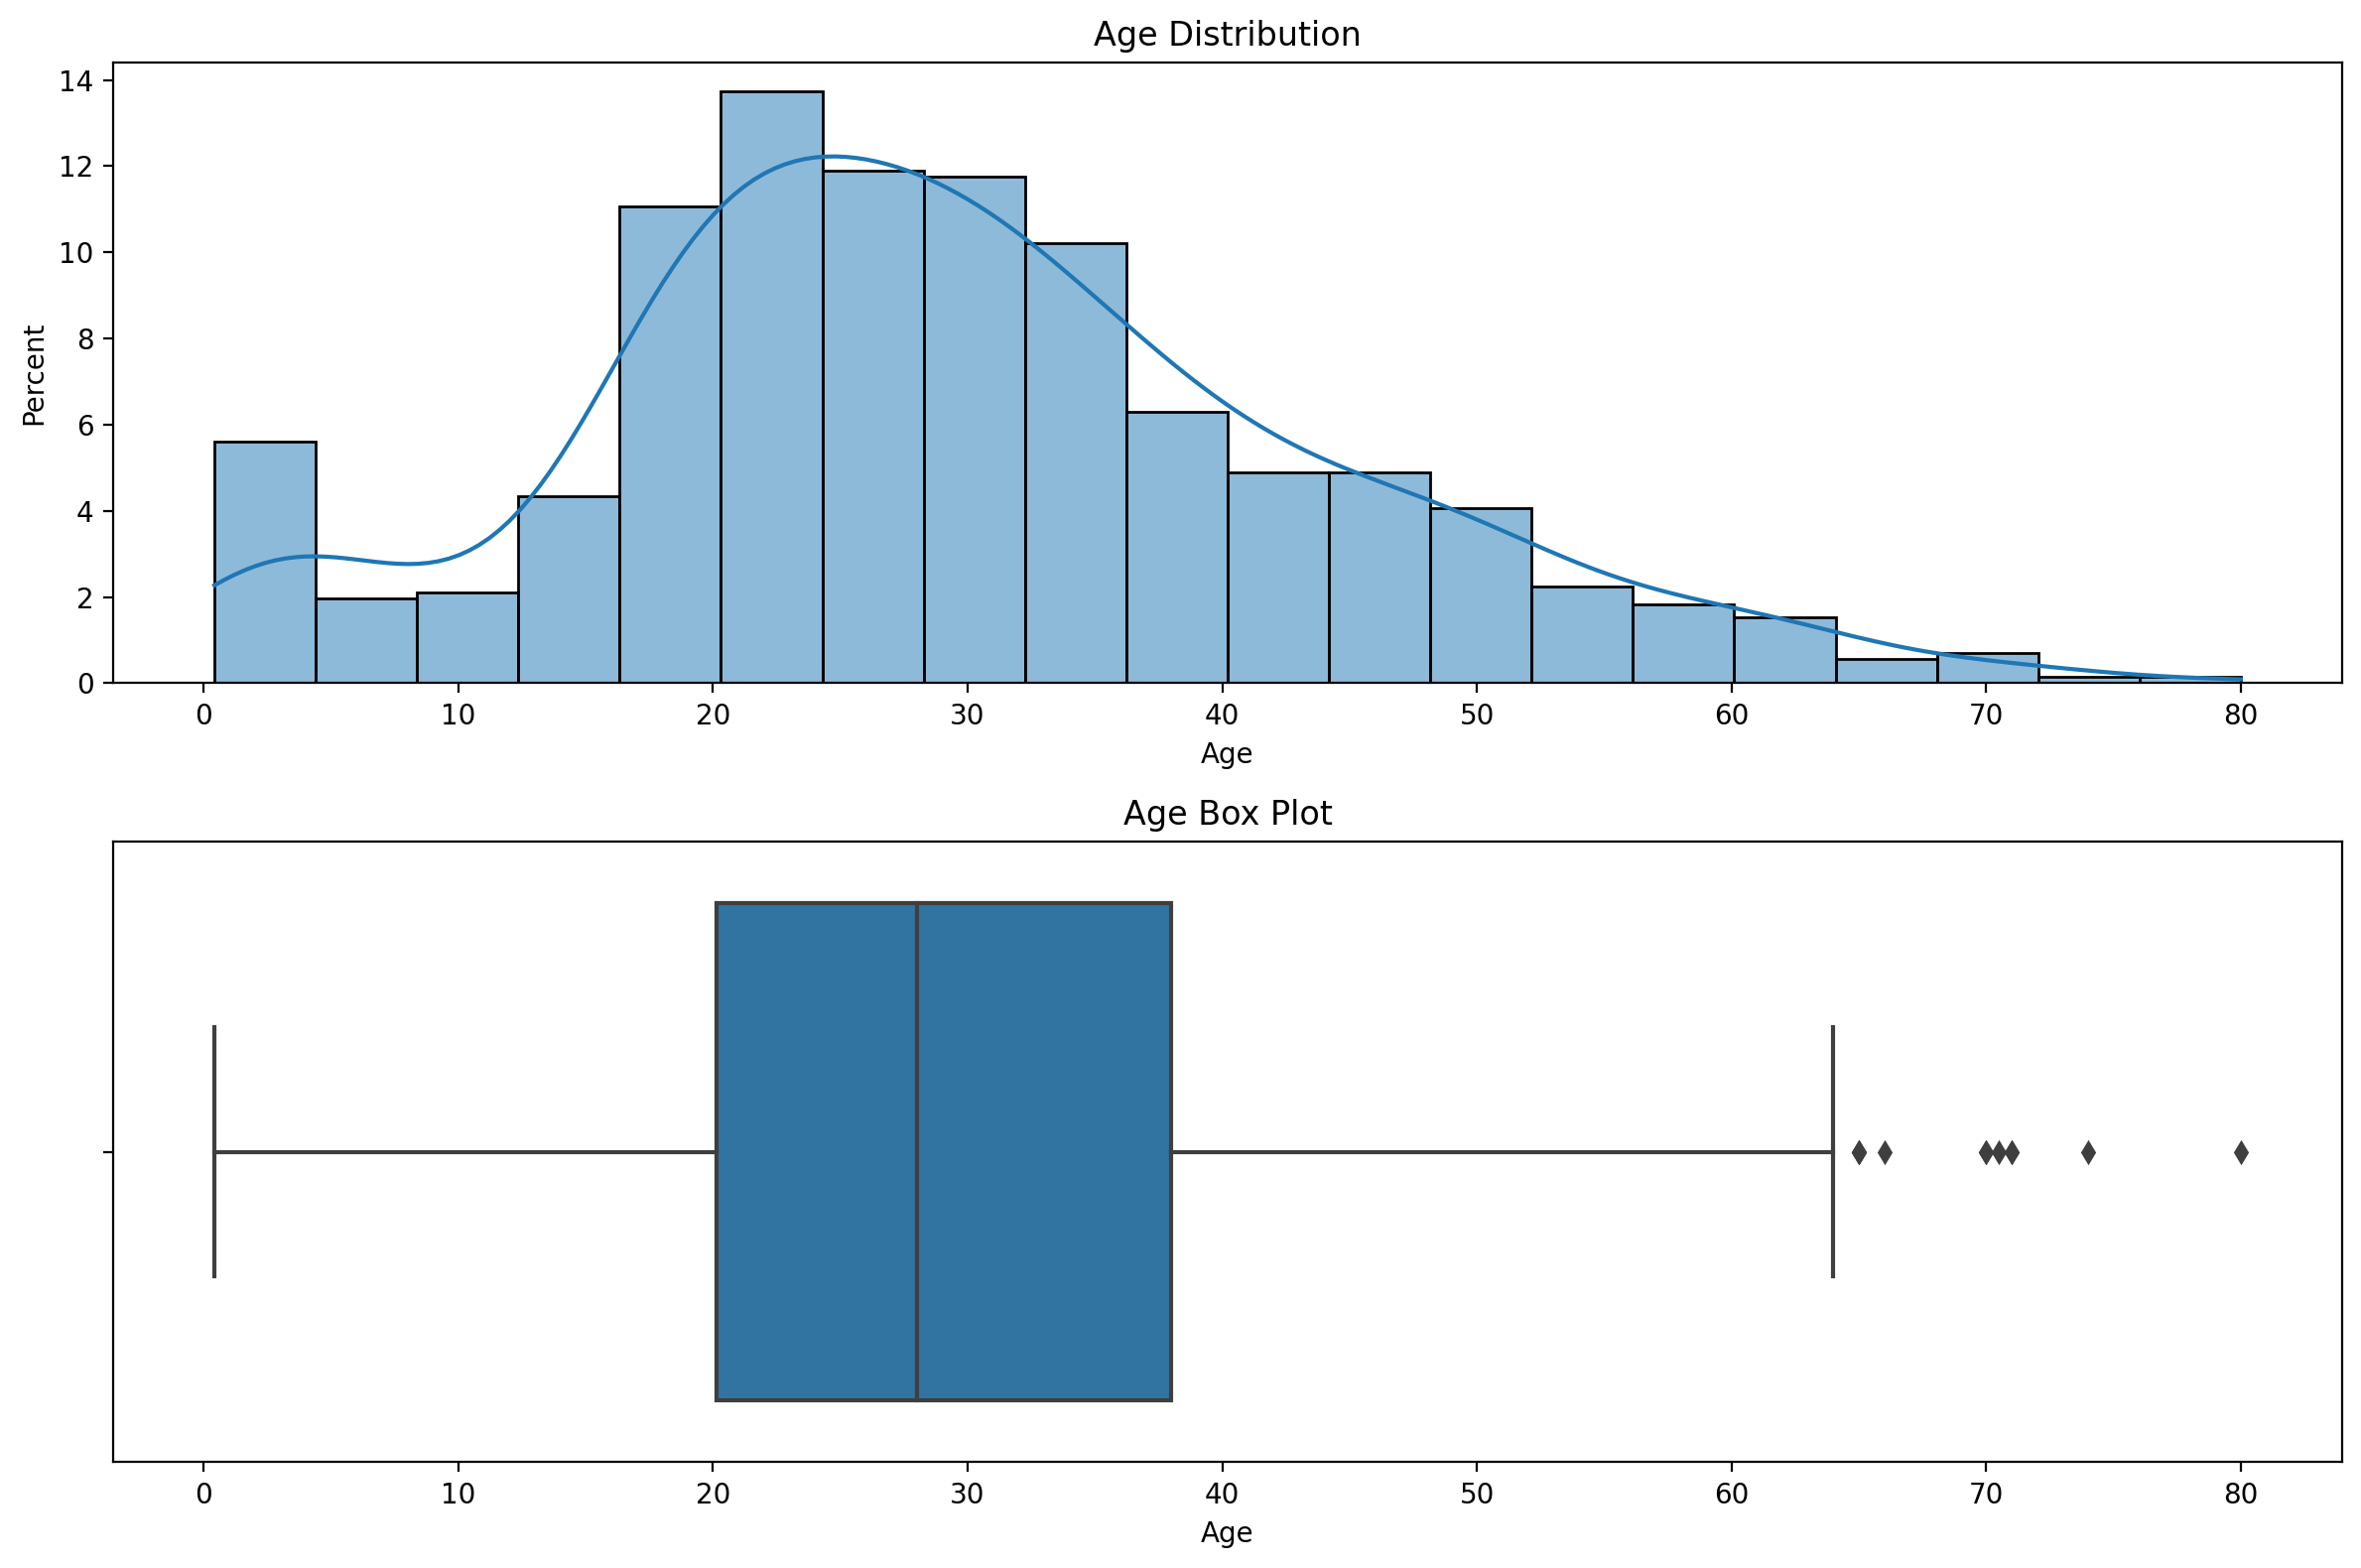

In [6]:
fig, axes = plt.subplots(2, figsize=(12,8))

sns.histplot(df.Age, kde=True, stat="percent", ax = axes[0])
axes[0].set_title("Age Distribution")

sns.boxplot(x=df.Age, ax=axes[1])
axes[1].set_title("Age Box Plot")

plt.tight_layout()
plt.show()

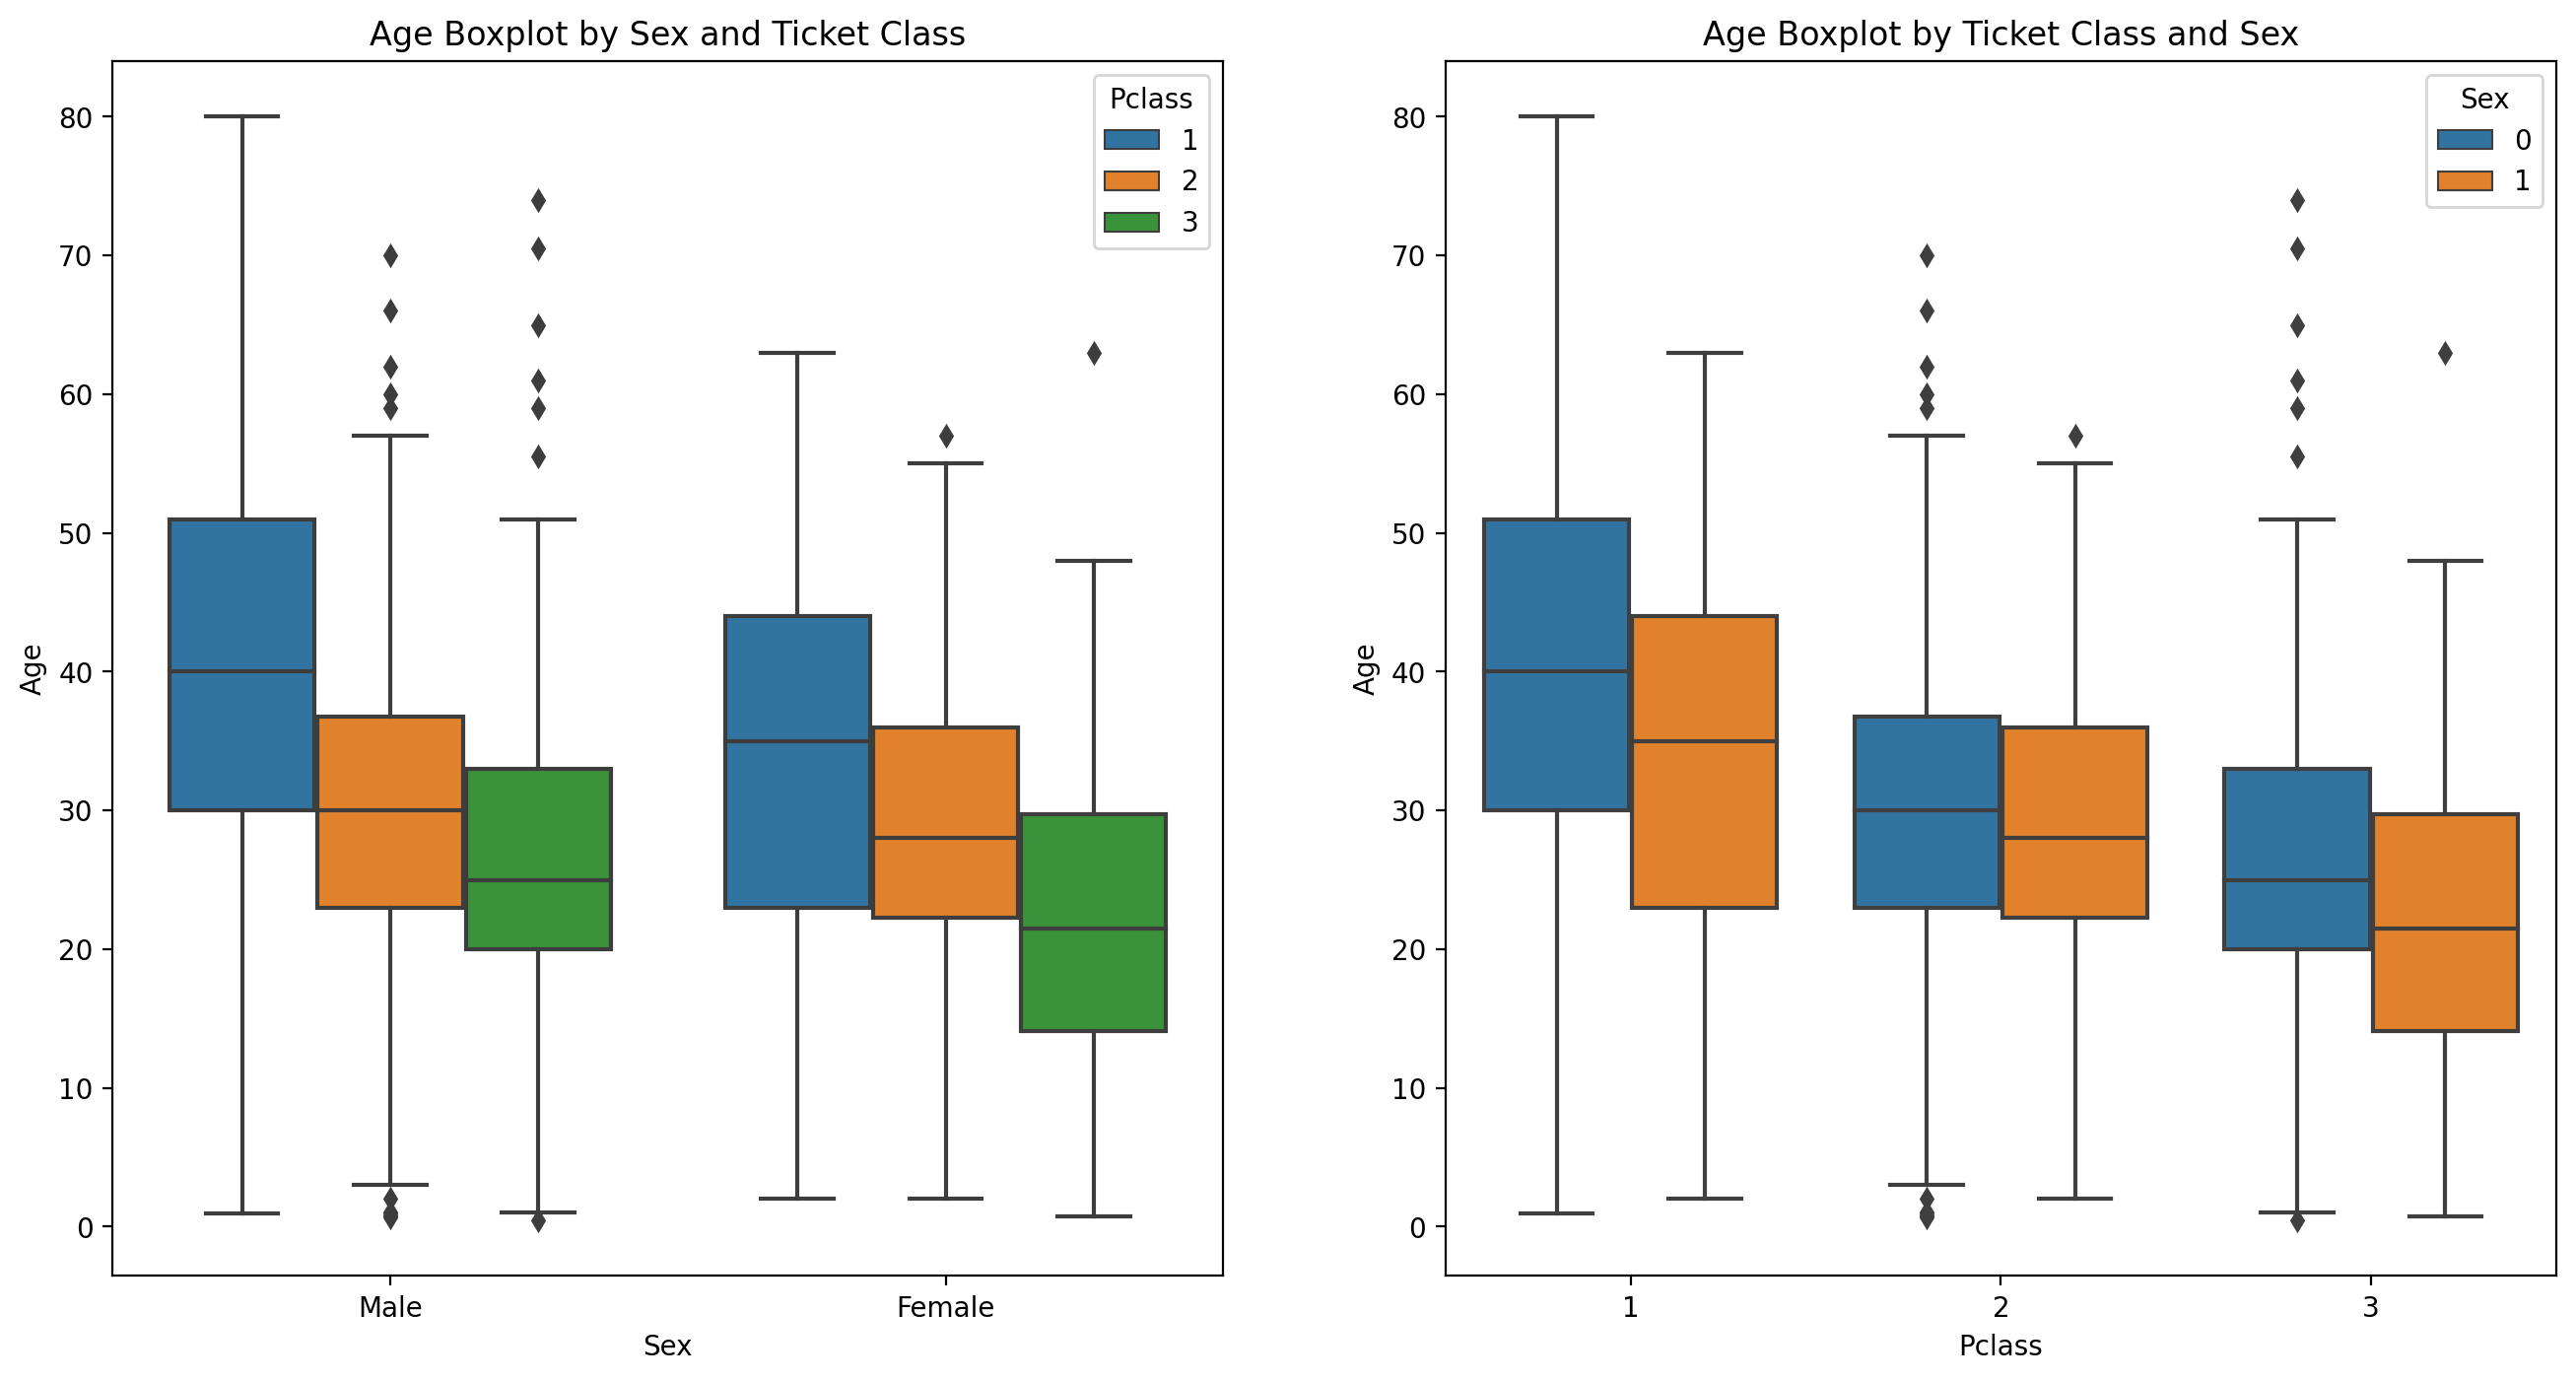

In [7]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

sns.boxplot(data=df, x="Sex", y="Age", hue="Pclass", ax=axes[0])
axes[0].set_xticks(ticks=[0, 1], labels=["Male", "Female"])
axes[0].set_title("Age Boxplot by Sex and Ticket Class")

sns.boxplot(data=df, x="Pclass", y="Age", hue="Sex", ax=axes[1])
axes[1].set_title("Age Boxplot by Ticket Class and Sex")

plt.show()

From this boxplot comparison it becomes evident that the class has a greater influence on age than sex. This makes sense since as you grow old you can make more money to purchase a more expensive ticket in a higher class.

## Fare

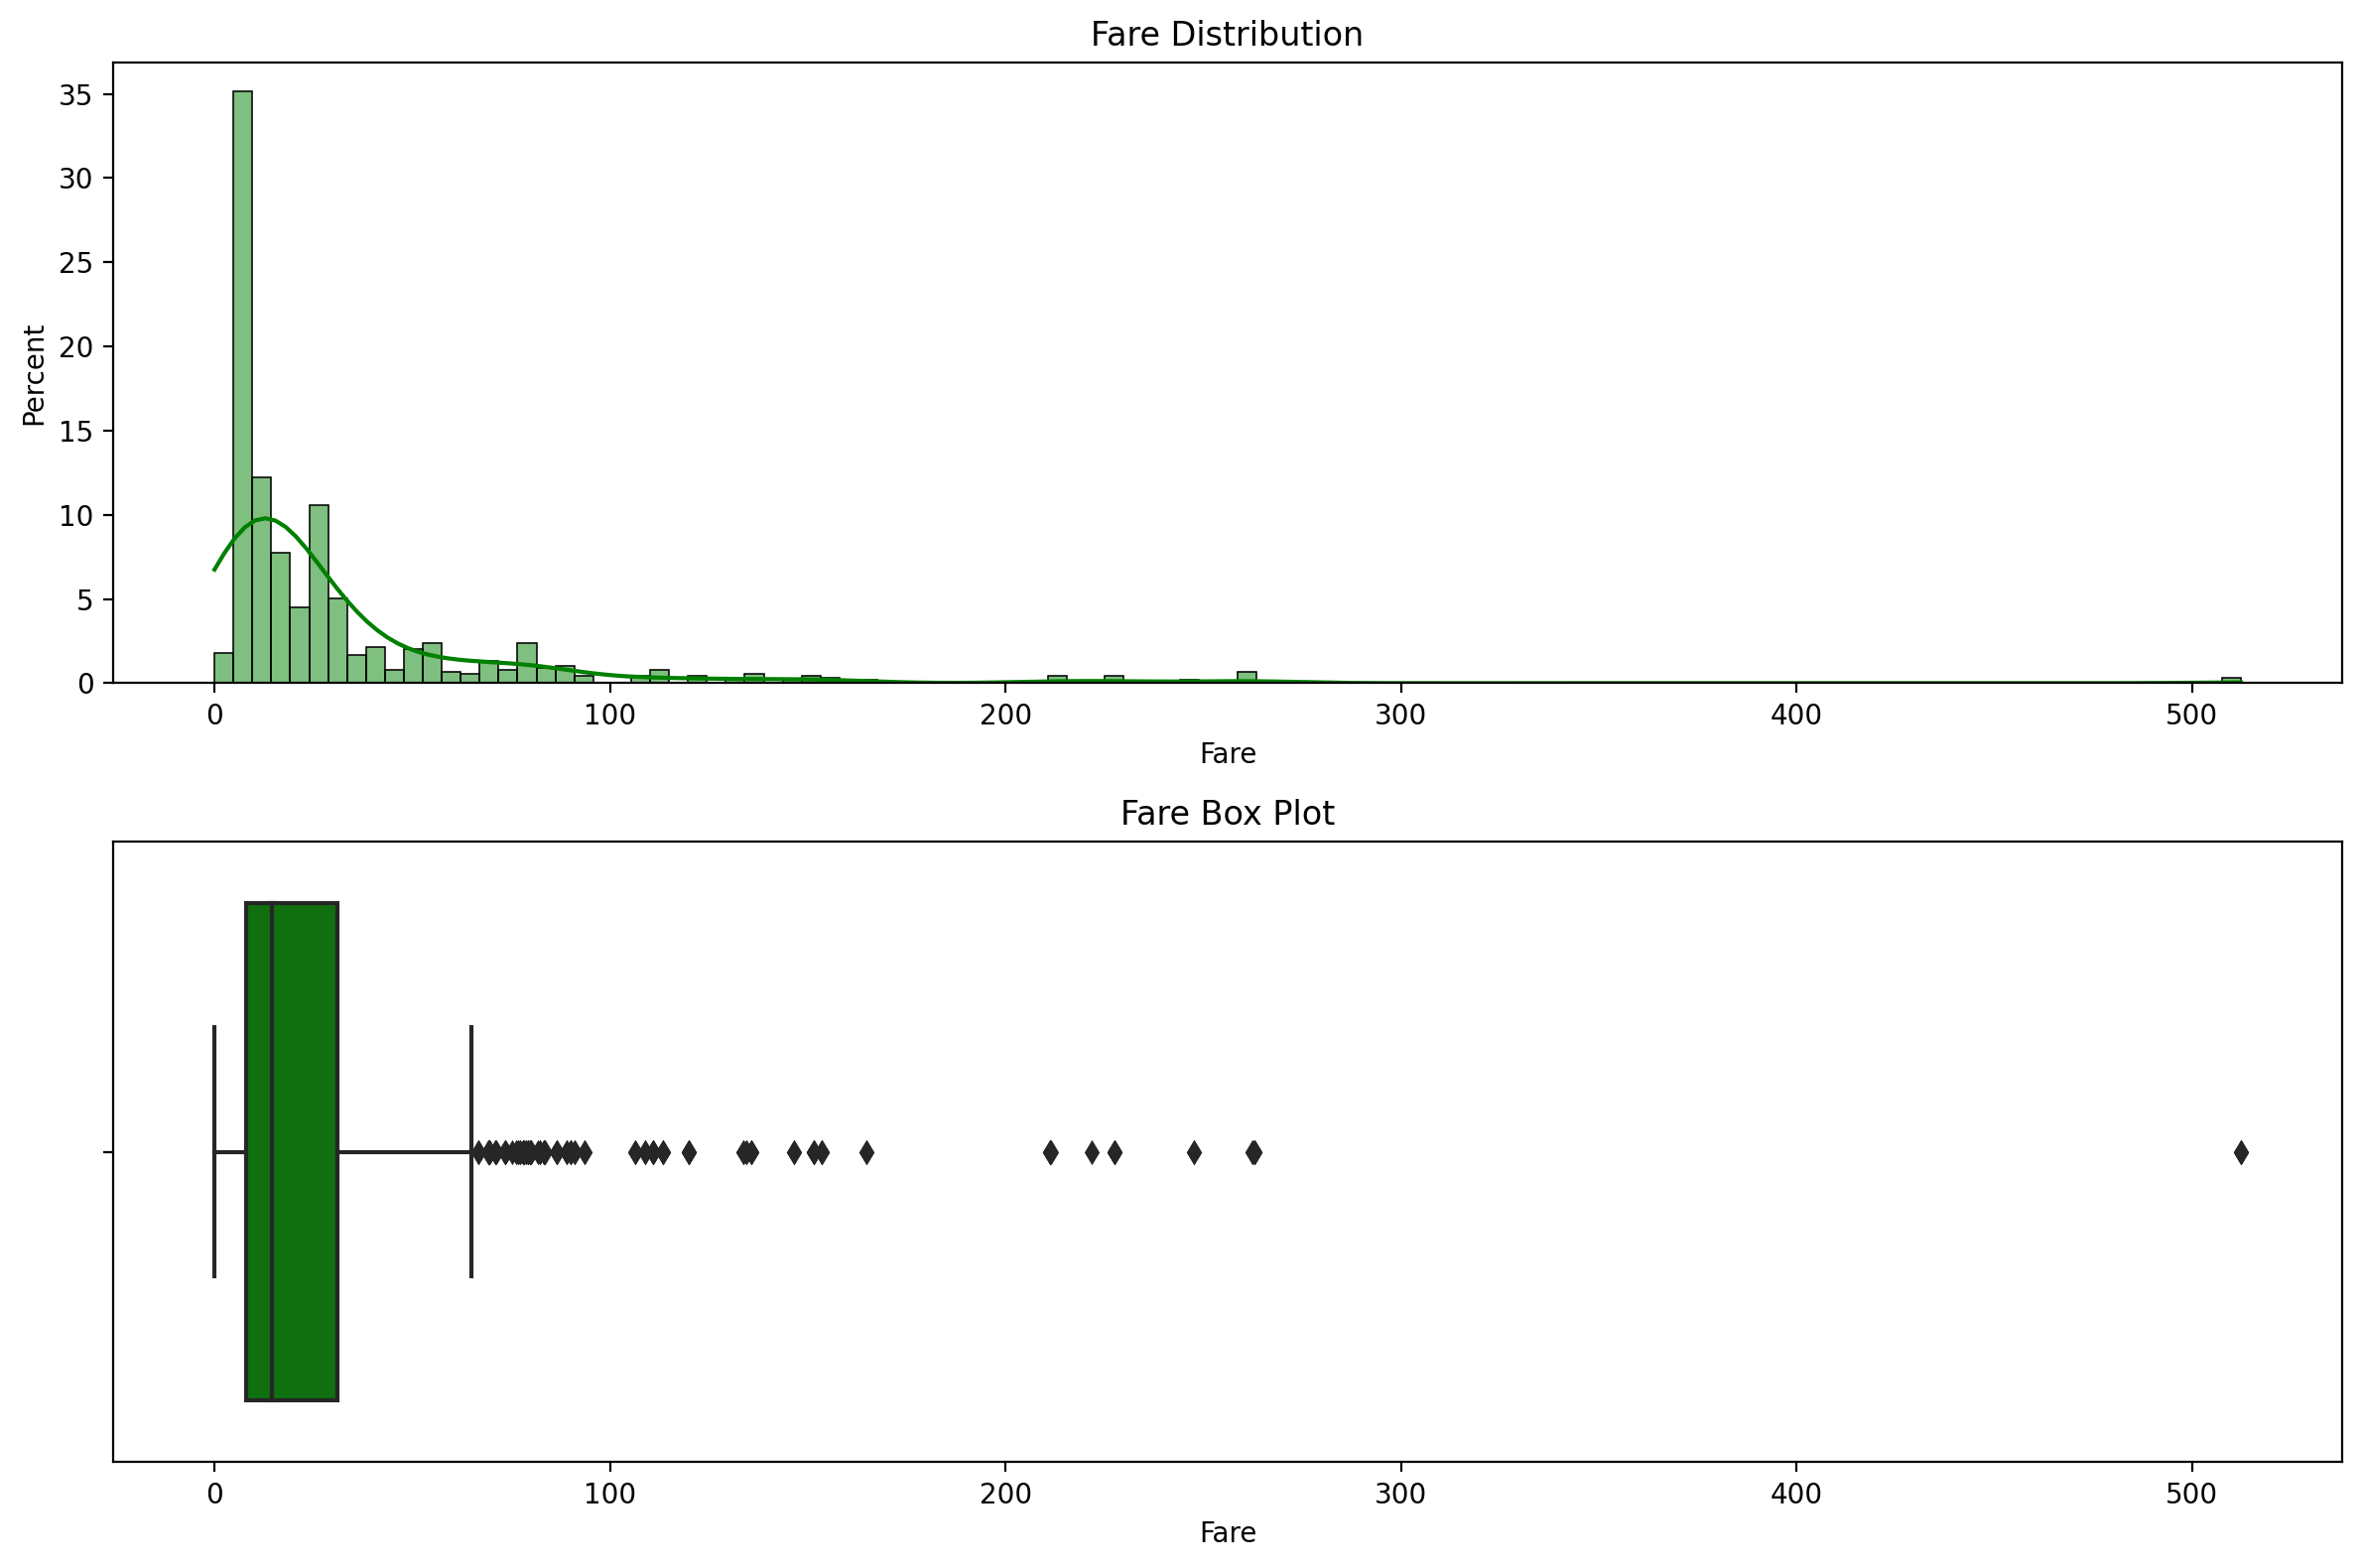

In [8]:
fig, axes = plt.subplots(2, figsize=(12,8))

sns.histplot(data=df, x="Fare", kde=True, stat="percent", color="green", ax = axes[0])
axes[0].set_title("Fare Distribution")

sns.boxplot(data=df, x="Fare", color="green", ax=axes[1])
axes[1].set_title("Fare Box Plot")

plt.tight_layout()
plt.show()

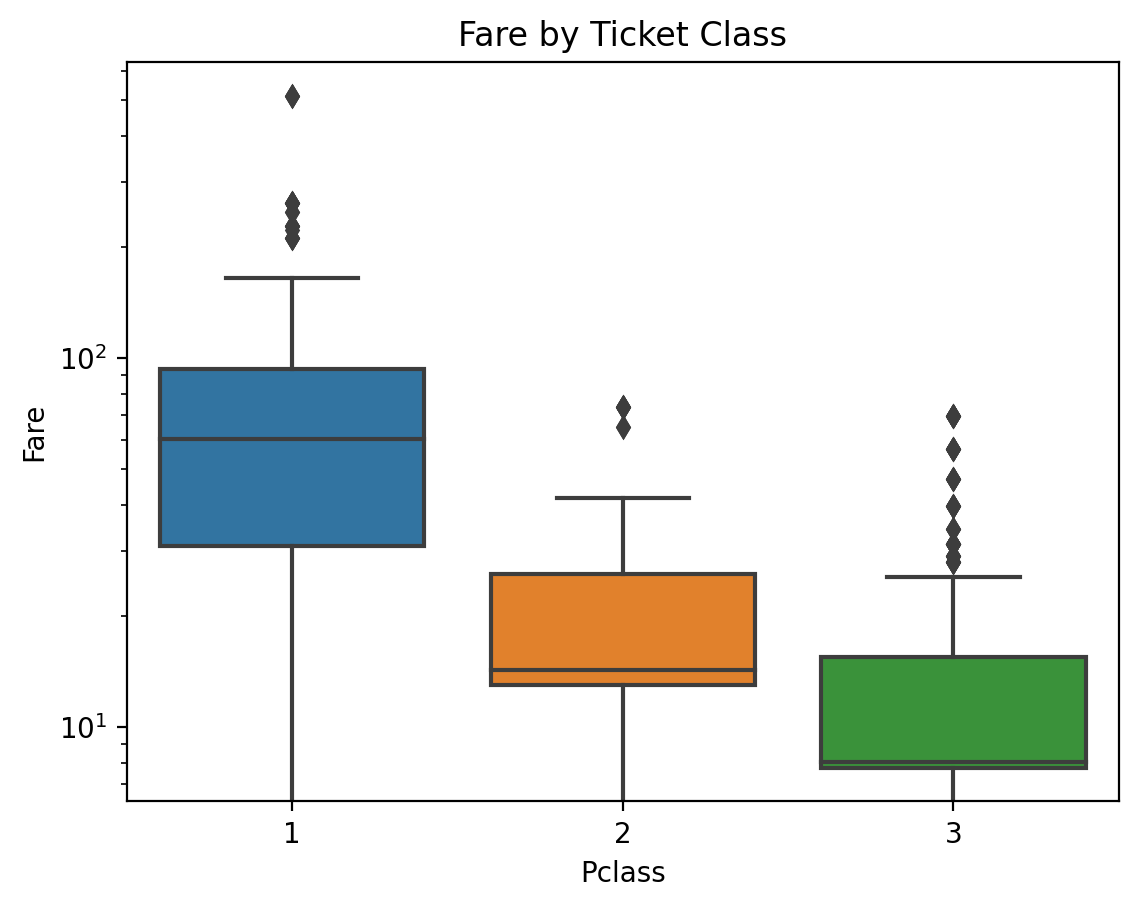

In [9]:
fig, ax = plt.subplots()
sns.boxplot(data=df, x="Pclass", y="Fare")
ax.semilogy()
plt.title("Fare by Ticket Class")
plt.show()

## Null values handling

In [10]:
# df.Age.fillna(df.Age.mean, inplace=True)

## Feature Extraction

In [11]:
# Lone travelers
alone = (df.SibSp < 1) & (df.Parch < 1)
df["Alone"] = alone.astype(int)

In [12]:
# Ticket Class
df[["Class1", "Class2", "Class3"]] = pd.get_dummies(df.Pclass)

In [13]:
# Embarking place
df[["Cherbourg", "Queenstown", "Southampton"]] = pd.get_dummies(df.Embarked)
# df.drop(columns=["Embarked", "Pclass"], inplace=True)

## Cabins and Classes

In [14]:
cabin = df[df.Cabin.notna()].dropna()

decks = ["A", "B", "C", "D", "E"]
for d in decks:
    titanic_class = cabin.Cabin.str.contains(d).astype(int)
    cabin["Deck_"+d] = titanic_class

cabin.sum(numeric_only=True)

Survived         123.0000
Pclass           218.0000
Sex               88.0000
Age             6528.4200
SibSp             85.0000
Parch             87.0000
Fare           14398.8918
Alone             79.0000
Class1           158.0000
Class2            15.0000
Class3            10.0000
Cherbourg         65.0000
Queenstown         2.0000
Southampton      116.0000
Deck_A            12.0000
Deck_B            43.0000
Deck_C            51.0000
Deck_D            31.0000
Deck_E            30.0000
dtype: float64

In [15]:
# fig, ax = plt.subplots(figsize=(14,8))
# sns.heatmap(cabin.corr(numeric_only=True), annot=True)
# plt.show()

In [16]:
# for i,d in enumerate(decks):
#     titanic_class = first_class_cabin.str.contains(d).astype(int)
#     first_class_cabin[[d]] = titanic_class

In [17]:
# Feature extraction idea: family divisions? Lone travelers?
# df[df.Name.str.contains("Palsson")]
# df[(df.SibSp < 2) & (df.Parch > 2)]

# Travel alone category
# Parent, number of children
# Child, number of siblings